In [27]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.20.0
[]


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Activation
from keras import optimizers 
from keras.activations import tanh
from keras.utils import get_custom_objects

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
dataraw = pd.read_csv('./BTC-USD.csv',index_col='Date', parse_dates=['Date'])
dataraw = pd.DataFrame(dataraw, )

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2020-07-05,9126.090820,9162.183594,8977.015625,9073.942383,9073.942383,12903406143
2020-07-06,9072.849609,9375.474609,9058.664063,9375.474609,9375.474609,17889263252
2020-07-07,9349.161133,9360.617188,9201.815430,9252.277344,9252.277344,13839652595


In [4]:
dataraw = pd.read_csv('./btc_usd_5m_bitstamp_18-08-2011_27-04-2021.csv')
dataraw['datetime'] = pd.to_datetime(dataraw['Timestamp'], unit='ms')
dataraw

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1313670900000,10.90,10.90,10.90,10.90,0.489908,2011-08-18 12:35:00
1,1313671200000,10.90,10.90,10.90,10.90,0.000000,2011-08-18 12:40:00
2,1313671500000,10.90,10.90,10.90,10.90,0.000000,2011-08-18 12:45:00
3,1313671800000,10.90,10.90,10.90,10.90,0.000000,2011-08-18 12:50:00
4,1313672100000,10.90,10.90,10.90,10.90,0.000000,2011-08-18 12:55:00
...,...,...,...,...,...,...,...
1020523,1619521800000,54880.96,54942.83,54855.47,54917.44,11.533485,2021-04-27 11:10:00
1020524,1619522100000,54923.58,55034.91,54923.58,54973.89,14.826969,2021-04-27 11:15:00
1020525,1619522400000,54974.25,54984.75,54736.39,54761.08,10.944628,2021-04-27 11:20:00
1020526,1619522700000,54761.08,54826.45,54737.21,54812.75,7.232430,2021-04-27 11:25:00


 Count row of data:  1020528


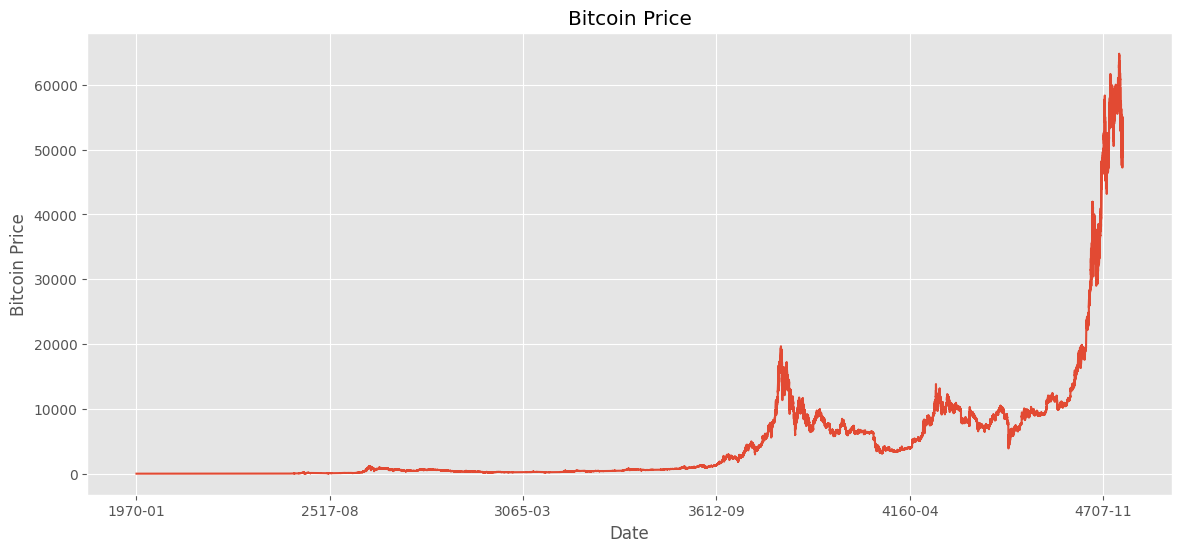

In [5]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Bitcoin Price')
plt.show()

In [6]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
0,0.000134
1,0.000134
2,0.000134
3,0.000134
4,0.000134
...,...
1020523,0.847486
1020524,0.848357
1020525,0.845073
1020526,0.845870


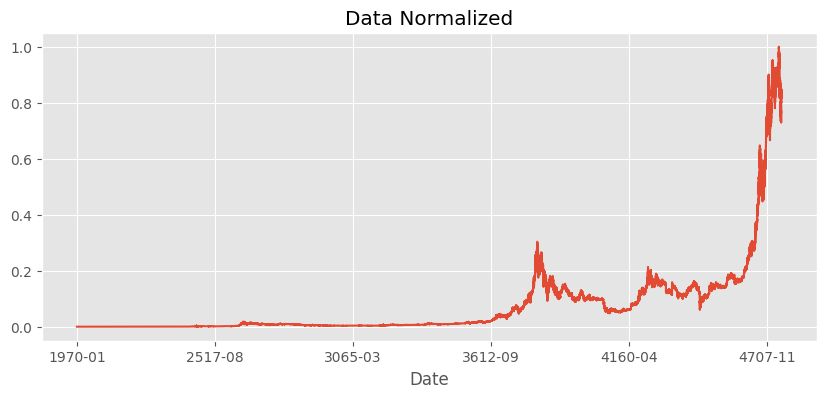

In [7]:
fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

In [8]:
# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

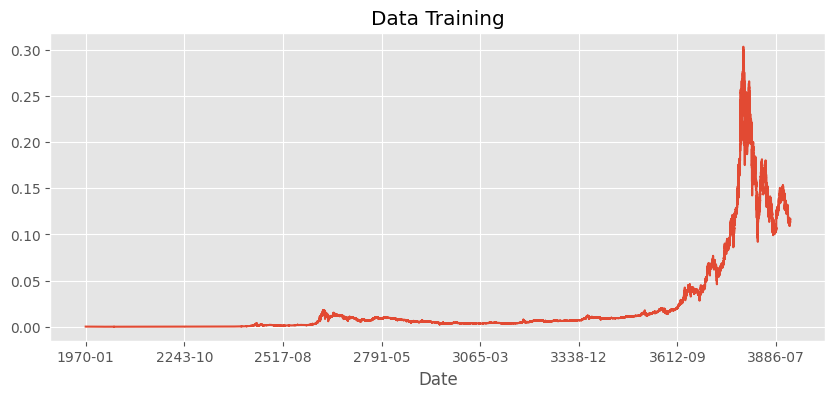

In [9]:
# graph of data training
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

In [10]:
# Initiaton value of lag
lag = 288
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag * 2,len_data - lag, lag):
        x.append(data[i - lag * 2: i - 1, 0])
        y.append(data[i : i + lag,0]) 
        
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [35]:
class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

In [ ]:
from keras.layers import RepeatVector
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 128
batch_size=1024
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressorGRU.add(Activation(double_tanh))
regressorGRU.add(Dropout(0.3))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True))
regressorGRU.add(Activation(double_tanh))
regressorGRU.add(Dropout(0.3))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False))
regressorGRU.add(Activation(double_tanh))
regressorGRU.add(Dropout(0.3))

# Output layer
regressorGRU.add(Dense(units=288))
regressorGRU.add(Activation(double_tanh))


# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),loss='mean_squared_error')
print(x_train.shape[1],1)
regressorGRU.summary()
# Fitting ke data training dan data validation
pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

575 1


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 575, 128)       │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 575, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 575, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 288)            │        37,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 288)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,600 (1.09 MB)

 Trainable params: 285,600 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - loss: 0.0033

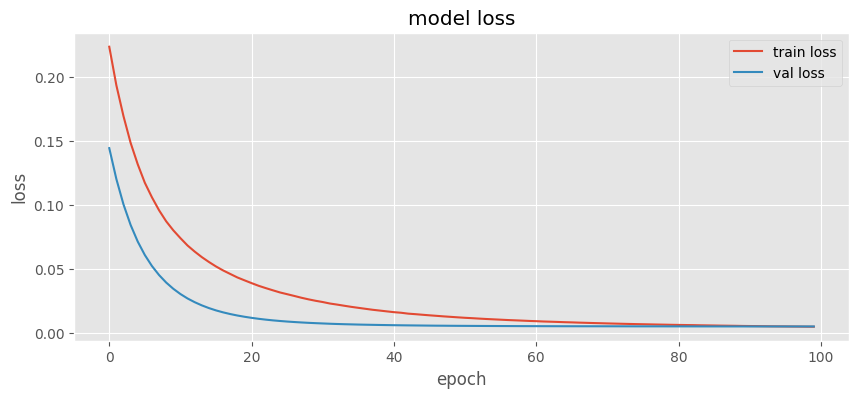

In [12]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [13]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


In [28]:
y_pred_invert_norm.shape, x_test.shape

((706, 288), (706, 575, 1))

In [17]:
_y = np.reshape(y_pred_invert_norm, [y_pred_invert_norm.shape[0] * y_pred_invert_norm.shape[1]])
_y.shape

(203328,)

In [ ]:
myxtest = np.array([[[0.2],[0.5]]])
myxtest

array([[[0.2],
        [0.5]]])

In [ ]:
myytest = regressorGRU.predict(myxtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
myytest
myxtest[0,0] = myxtest[0,1]
myxtest[0,1] = myytest[0,0]
myytest = regressorGRU.predict(myxtest)
myytest

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.42311236]], dtype=float32)

In [ ]:
myytest = regressorGRU.predict(myxtest)
myy = []
myy.append(myytest[0,0])
for i in range(1000):
    myxtest[0,0] = myxtest[0,1]
    myxtest[0,1] = myytest[0,0]
    print(i)
    print(myxtest)
    myytest = regressorGRU.predict(myxtest)
    myy.append(myytest[0,0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0
[[[0.28303334]
  [0.42311236]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1
[[[0.42311236]
  [0.31671846]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2
[[[0.31671846]
  [0.38056344]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3
[[[0.38056344]
  [0.32696655]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4
[[[0.32696655]
  [0.35450858]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5
[[[0.35450858]
  [0.32613912]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6
[[[0.32613912]
  [0.33643293]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7
[[[0.33643293]
  [0.32014078]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8
[[[0.32014078]
  [0.32227579]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
9
[[[0.32227579]
  [0.31179342]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10
[[[0.31179342]
  [0.31010413]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
11
[[[0.31010413]
  [0.30244711]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
12
[[[0.30244711]
  [0.29899999]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13
[[[0.29899999]
  [0.

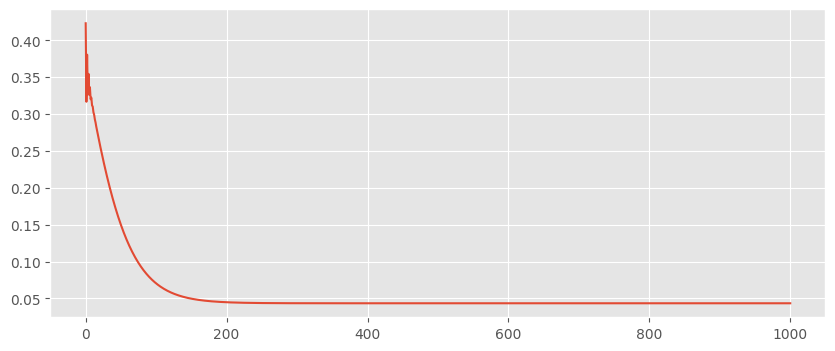

In [ ]:
# graph of data test
fig = plt.figure(figsize=(10, 4))
plt.plot(myy)
plt.show()

In [19]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [15]:
y_pred_invert_norm

array([[1304.2312 ,  426.92508, 1238.5317 , ..., -426.35376, 1297.8574 ,
        1158.4307 ],
       [1304.2328 ,  426.90854, 1238.5453 , ..., -426.37585, 1297.8431 ,
        1158.4014 ],
       [1304.2316 ,  426.93008, 1238.5266 , ..., -426.34158, 1297.8613 ,
        1158.4424 ],
       ...,
       [1304.1193 ,  429.5397 , 1236.2065 , ..., -423.2018 , 1299.7211 ,
        1162.5658 ],
       [1304.1206 ,  429.54987, 1236.1969 , ..., -423.18817, 1299.7267 ,
        1162.5837 ],
       [1304.1185 ,  429.5475 , 1236.2109 , ..., -423.20822, 1299.7229 ,
        1162.5657 ]], shape=(706, 288), dtype=float32)

In [16]:
_y.shape

NameError: name '_y' is not defined

In [18]:
# Comparison data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(dataset['Close'][-203328:])
datapred= _y

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(datatest, datapred))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Result Mean Absolute Percentage Error Prediction Model : ', mape(datatest, datapred), '%')

Result Root Mean Square Error Prediction Model : 21438.9566
Result Mean Absolute Percentage Error Prediction Model :  89.7569 %


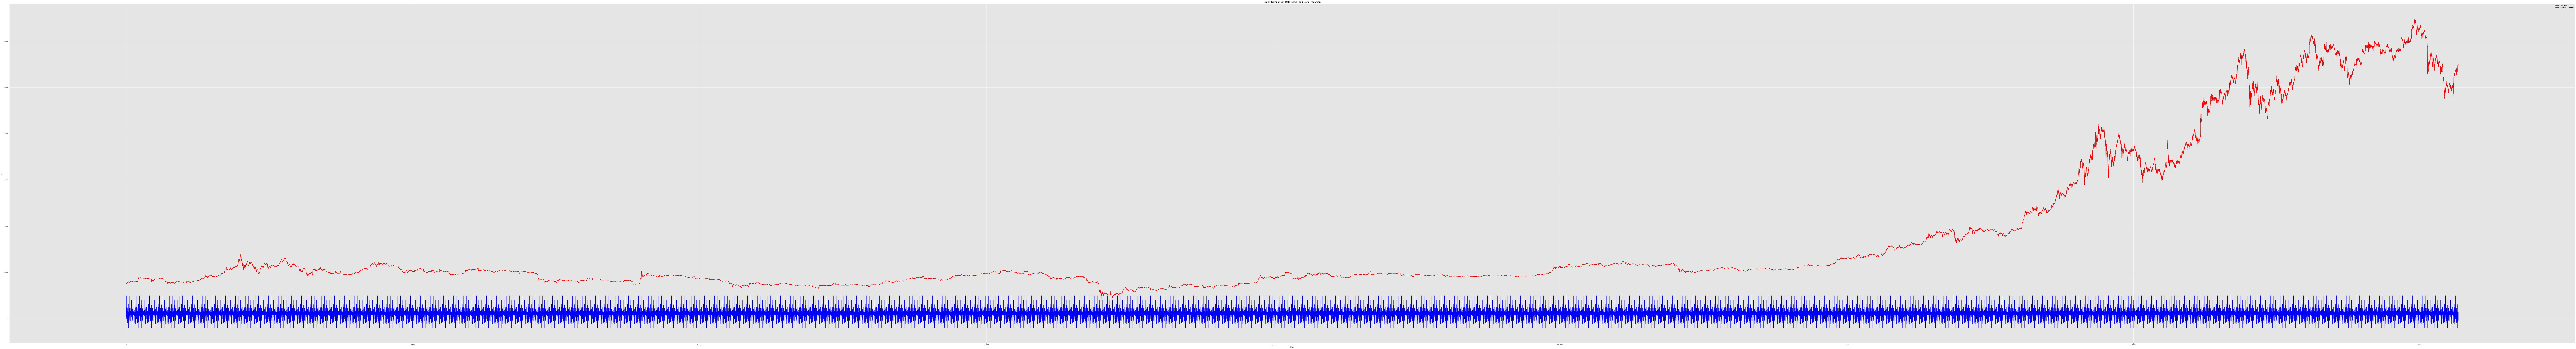

In [19]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(300, 40), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
for i in range(y_test.shape[0]):
    print(x_test[i])
    print(y_test[i])

[[0.35168301]
 [0.3952945 ]]
0.4045857807350749
[[0.3952945 ]
 [0.40458578]]
0.4154946636366012
[[0.40458578]
 [0.41549466]]
0.39891751890482435
[[0.41549466]
 [0.39891752]]
0.37091372244191434
[[0.39891752]
 [0.37091372]]
0.3671512926536376
[[0.37091372]
 [0.36715129]]
0.415107562809492
[[0.36715129]
 [0.41510756]]
0.4037520581792103
[[0.41510756]
 [0.40375206]]
0.40297659286620013
[[0.40375206]
 [0.40297659]]
0.3883145052530846
[[0.40297659]
 [0.38831451]]
0.3987589986471928
[[0.38831451]
 [0.398759  ]]
0.4042211487375079
[[0.398759  ]
 [0.40422115]]
0.4075945821328453
[[0.40422115]
 [0.40759458]]
0.4397216239384592
[[0.40759458]
 [0.43972162]]
0.4465832865187988
[[0.43972162]
 [0.44658329]]
0.44214128201654945
[[0.44658329]
 [0.44214128]]
0.4390110124332513
[[0.44214128]
 [0.43901101]]
0.42141127047145516
[[0.43901101]
 [0.42141127]]
0.43461202471277693
[[0.42141127]
 [0.43461202]]
0.43406928494400043
[[0.43461202]
 [0.43406928]]
0.44333159932117006
[[0.43406928]
 [0.4433316 ]]
0.41

In [36]:
import yfinance as yf
import numpy as np
import h5py

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [39]:
def get_btc_returns(days=60):
    df = yf.download("BTC-USD", period=f"{days}d", interval="5m")
    df = df["Close"].dropna()
    log_returns = np.log(df / df.shift(1)).dropna()
    return log_returns.values

In [40]:
print("Fetching historical BTC data...")
returns = get_btc_returns(days=30)
returns

Fetching historical BTC data...


Failed to get ticker 'BTC-USD' reason: Failed to perform, curl: (28) Failed to connect to fc.yahoo.com port 443 after 21042 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-USD']: Timeout('Failed to perform, curl: (28) Failed to connect to fc.yahoo.com port 443 after 21023 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


array([], shape=(0, 1), dtype=float64)